# 巴西预约挂号实际就诊的数据分析

# 目录

<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>


<a id='intro'></a>

# 简介

> 本数据集包含10万条巴西预约挂号的求诊信息，研究病人是否如约前往医院就诊。每行数据录入了有关患者特点的多个数值，包括 “预约日期 (ScheduledDay)”指患者具体预约就诊的日期；“街区 (Neighborhood) ”指医院所在位置；“福利保障 (Scholarship)”说明病人是否是巴西福利项目 Bolsa Família 的保障人群；请注意最后一列内容的编码：“No”表示病人已如约就诊，“Yes”说明病人未前往就诊。


本次将依托数据集，讨论以下问题：
1. 不同性别实际就诊人数比例，男的占比大还是女的占比大？
2. 预定时间离就诊时间越近，患者是否更容易成功就诊？*实际就诊成功率 = 实际就诊人数/预约人数 x 100%*
3. 不同年龄段实际就诊患者数量趋势是怎样的？
4. 办理了家庭补助金（scholarship）的患者，是否更愿意就诊？
5. 患有高血压（hypertension）、糖尿病（diabetes）、酗酒（alcoholism）的患者，和其他普通患者相比，是否更不愿意就诊？
6. 消息提醒是否影响实际就诊成功率？

<a id='wrangling'></a>

# 数据整理

## 预览数据内容

In [227]:
# 导入模块
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [228]:
# 加载csv数据
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [229]:
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


## 整理列标签

* 处理数据列标签，遵循无空格，全小写，单词间隔用“_”的原则
* 发现以下标签有拼写错误：`Hipertension`、`Handcap`

In [230]:
# 处理需要用单词间隔的标签，处理拼写错误的标签
df.rename(
    columns={
        'PatientId': 'Patient_Id',
        'AppointmentID': 'Appointment_ID',
        'ScheduledDay': 'Scheduled_Day',
        'AppointmentDay': 'Appointment_Day',
        'Hipertension': 'hypertension',
        'Handcap': 'handicap',
        'No-show': 'No_show'
    },
    inplace=True)

In [231]:
# 列标签全小写
df.rename(columns=lambda x: x.strip().lower(), inplace=True)

In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         110527 non-null float64
appointment_id     110527 non-null int64
gender             110527 non-null object
scheduled_day      110527 non-null object
appointment_day    110527 non-null object
age                110527 non-null int64
neighbourhood      110527 non-null object
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


## 检查异常数据

In [233]:
# 查询缺失值
df.isnull().sum().sum()

0

In [234]:
# 查询重复行
df.duplicated().sum()

0

结论：数据无空值，无重复行

## 整理数据格式

* 以下时间相关字段，转换为时间格式：`scheduled_day`，`appointment_day`

In [235]:
df['scheduled_day'] = pd.to_datetime(df['scheduled_day'])
df['appointment_day'] = pd.to_datetime(df['appointment_day'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
patient_id         110527 non-null float64
appointment_id     110527 non-null int64
gender             110527 non-null object
scheduled_day      110527 non-null datetime64[ns]
appointment_day    110527 non-null datetime64[ns]
age                110527 non-null int64
neighbourhood      110527 non-null object
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: datetime64[ns](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB


## 新增列：预约间隔


* 新增预约间隔时间 `interval_day` = `appointment_day` - `scheduled_day`

In [236]:
df['interval_day'] = df['appointment_day'] - df['scheduled_day']
df.head(3)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,interval_day
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1 days +05:21:52
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1 days +07:51:33
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1 days +07:40:56


In [237]:
# 查看预约到就诊的间隔时间最大值
df['interval_day'].max()

Timedelta('178 days 13:19:01')

In [238]:
# 查看预约到就诊的间隔时间最小值
df['interval_day'].min()

Timedelta('-7 days +10:10:40')

In [239]:
# 处理interval_day的数据，只保留到天
df['interval_day'] = df['interval_day'].apply(lambda x: x.days)
df['interval_day'].max()

178

In [240]:
# 处理interval_day异常的数据，-1表示当天
df = df[df['interval_day'] >= -1]

In [241]:
# 查看interval_day的统计数据，获取min、25%、50%、75%、max用作分段
df['interval_day'].describe()

count    110522.000000
mean          9.184253
std          15.255115
min          -1.000000
25%          -1.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: interval_day, dtype: float64

In [242]:
# 数据“分割”成组，用刚才计算的五个值填充这个列表
int_edges = [-2, 0, 3, 14, 178]

In [243]:
# 设置分组的标签
int_names = ['1day', '3days', '2weeks', 'moreweeks']

In [244]:
# 创建 interval_levels 列
df['interval_levels'] = pd.cut(df['interval_day'], int_edges, labels=int_names)

# 检查该列是否成功创建
df.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,interval_day,interval_levels
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1,1day
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1,1day
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1,1day
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1,1day
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1,1day


## 新增列：特殊疾病数量

In [245]:
# 设置 disease_num 列初始值
df['disease_num'] = df['gender'].apply(lambda x: 0)

In [246]:
# 统计特殊疾病数量
disease_rows = ['hypertension', 'diabetes', 'alcoholism']
for c in disease_rows:
    df['disease_num'] = df['disease_num'] + df[c]

In [247]:
# 检查 disease_num 列是否有异常值
df.disease_num.unique()

array([1, 0, 2, 3], dtype=int64)

In [248]:
# 检查该列是否成功创建
df.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,interval_day,interval_levels,disease_num
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1,1day,1
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1,1day,0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1,1day,0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1,1day,0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1,1day,2


## 新增子集：实际就诊

In [249]:
# 获取实际就诊数据
df_show = df[df['no_show'] == 'Yes']

<a id='eda'></a>

# 探索性数据分析

## 不同性别实际就诊人数比例，男的占比大还是女的占比大？

In [29]:
# 检查gender列是否有异常值
df.gender.unique()

array(['F', 'M'], dtype=object)

In [30]:
# 检查no_show列是否有异常值
df.no_show.unique()

array(['No', 'Yes'], dtype=object)

In [111]:
# 获取不同性别实际就诊数量
df_show_gender = df_show.groupby(['gender']).count()['appointment_id']
df_show_gender

gender
F    14272
M     7403
Name: appointment_id, dtype: int64

In [89]:
# 获取总就诊人数
df_show_gender_all = df_show_gender.sum()
df_show_gender_all

21675

In [90]:
# 计算不同性别实际就诊成功率
df_show_gender_proportions = df_show_gender / df_show_gender_all
df_show_gender_proportions

gender
F    0.658454
M    0.341546
Name: appointment_id, dtype: float64

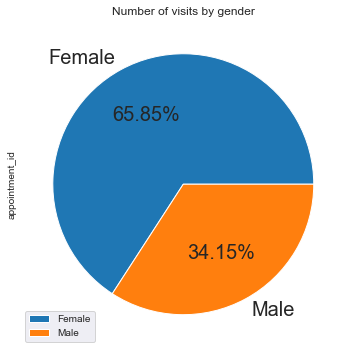

In [91]:
df_show_gender_proportions.plot(
    kind='pie',
    labels=['Female', 'Male'],
    title='Number of visits by gender',
    legend=True,
    fontsize=20,
    autopct='%.2f%%',
    figsize=(6, 6));

结果：
* 不同性别实际就诊人数比例，男性患者占 34.15%，女性患者占 65.85%
* 可以看出实际就诊人群中，女性比例大

## 预定时间离就诊时间越近，患者是否更容易成功就诊？

* 实际就诊成功率 = 实际就诊人数/预约人数 x 100%

In [112]:
# 获取不同时间段就诊数量
df_show_interval = df_show.groupby(
    ['interval_levels']).count()['appointment_id']
df_show_interval

interval_levels
1day         2816
3days        3416
2weeks       7131
moreweeks    8312
Name: appointment_id, dtype: int64

In [113]:
# 获取不同时间段预约数量
df_show_interval_all = df.groupby(['interval_levels']).count()['appointment_id']
df_show_interval_all

interval_levels
1day         42182
3days        14487
2weeks       25016
moreweeks    25297
Name: appointment_id, dtype: int64

In [114]:
# 计算不同时间段实际就诊成功率
df_show_interval_proportions = df_show_interval / df_show_interval_all
df_show_interval_proportions

interval_levels
1day         0.066758
3days        0.235798
2weeks       0.285058
moreweeks    0.328577
Name: appointment_id, dtype: float64

Text(0, 0.5, 'proportions')

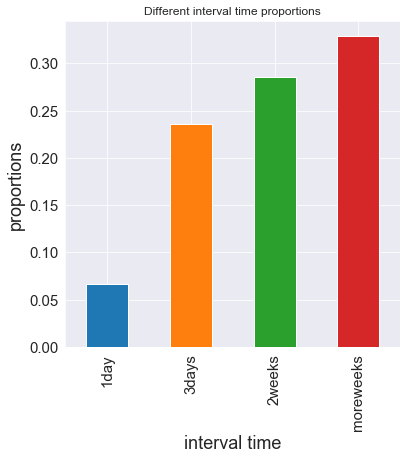

In [205]:
df_show_interval_proportions.plot(
    kind='bar',
    title='Different interval time proportions',
    fontsize=15,
    figsize=(6, 6));
plt.xlabel('interval time', fontsize=18)
plt.ylabel('proportions', fontsize=18)

结果：
* 实际就诊成功率最小是1天内预约的患者只有6.68%，最大是2周前预约的患者有32.86%
* 预约时间和就诊时间间隔越大，实际就诊概率越高

## 不同年龄段实际就诊患者数量趋势是怎样的？


Text(0, 0.5, 'proportions')

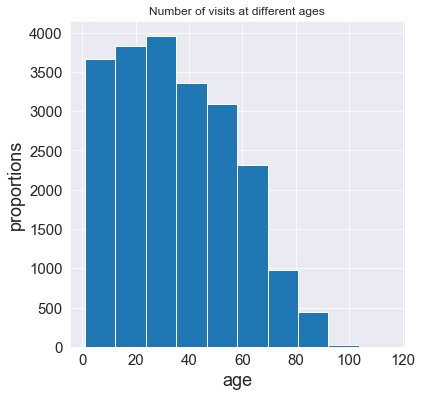

In [161]:
# 不同年龄段实际就诊人数趋势
df_show['age'].plot(
    kind='hist',
    title='Number of visits at different ages',
    fontsize=15,
    figsize=(6, 6));
plt.xlabel('age', fontsize=18)
plt.ylabel('proportions', fontsize=18)

结果：
* 对比各年龄段实际就诊人数，30岁左右患者人数最多，其次是20岁左右患者人数
* 70岁之后就诊患者人数最少

## 办理了家庭补助金（scholarship）的患者，是否更愿意就诊？


In [117]:
# 获取是否办理家庭补助金患者实际就诊数量
df_show_scholarship = df_show.groupby(
    ['scholarship']).count()['appointment_id']
df_show_scholarship

scholarship
0    19104
1     2571
Name: appointment_id, dtype: int64

In [118]:
# 获取是否办理家庭补助金患者预约数量
df_show_scholarship_all = df.groupby(['scholarship']).count()['appointment_id']
df_show_scholarship_all

scholarship
0    96173
1    10809
Name: appointment_id, dtype: int64

In [119]:
# 计算是否办理家庭补助金患者实际就诊成功率
df_show_scholarship_proportions = df_show_scholarship / df_show_scholarship_all
df_show_scholarship_proportions

scholarship
0    0.198642
1    0.237857
Name: appointment_id, dtype: float64

Text(0, 0.5, 'proportions')

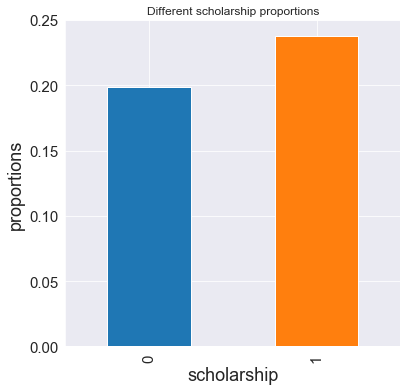

In [159]:
df_show_scholarship_proportions.plot(
    kind='bar',
    title='Different scholarship proportions',
    x=['No Handle', 'Handle'],
    fontsize=15,
    figsize=(6, 6));
plt.xlabel('scholarship', fontsize=18)
plt.ylabel('proportions', fontsize=18)

结果：
* 办理家庭补助金患者实际就诊率23.79%，没有办理的实际就诊率19.86%
* 办理家庭补助金患者更容易成功就诊

## 患有特殊疾病的患者，和其他普通患者相比，是否更不愿意就诊？

* 特殊疾病包括：高血压（hypertension）、糖尿病（diabetes）、酗酒（alcoholism）
* 患有特殊疾病数量在字段 `disease_num`


In [121]:
# 获取特殊疾病患者实际就诊数量
df_show_disease_num = df_show.groupby(
    ['disease_num']).count()['appointment_id']
df_show_disease_num

disease_num
0    17194
1     3129
2     1306
3       46
Name: appointment_id, dtype: int64

In [122]:
# 获取特殊疾病患者预约数量
df_show_disease_num_all = df.groupby(['disease_num']).count()['appointment_id']
df_show_disease_num_all

disease_num
0    81767
1    17582
2     7377
3      256
Name: appointment_id, dtype: int64

In [123]:
# 计算特殊疾病患者实际就诊成功率
df_show_disease_num_proportions = df_show_disease_num / df_show_disease_num_all
df_show_disease_num_proportions

disease_num
0    0.210280
1    0.177966
2    0.177037
3    0.179688
Name: appointment_id, dtype: float64

Text(0, 0.5, 'proportions')

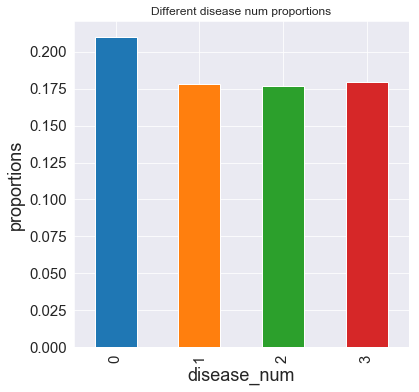

In [207]:
df_show_disease_num_proportions.plot(
    kind='bar',
    title='Different disease num proportions',
    fontsize=15,
    figsize=(6, 6))
plt.xlabel('disease_num', fontsize=18)
plt.ylabel('proportions', fontsize=18)

结果：
* 没有特殊疾病的患者，实际就诊率21%，而患有1种以上（包括1种）特殊疾病患者实际就诊率17.7%~18.0%
* 患有特殊疾病数量不影响实际就诊率

## 消息提醒是否影响实际就诊成功率？

* 相关字段：`no_show` , `sms_received`


In [199]:
# 查询没有消息提醒的患者实际就诊数量
df_show_sms_received_no = df[df['sms_received'] == 0].groupby(
    ['no_show']).count()['appointment_id']
df_show_sms_received_no

no_show
No     60290
Yes    12107
Name: appointment_id, dtype: int64

In [200]:
# 计算没有消息提醒的患者实际就诊数率
df_show_sms_received_no_pro = df_show_sms_received_no / df_show_sms_received_no.sum(
)
df_show_sms_received_no_pro

no_show
No     0.832769
Yes    0.167231
Name: appointment_id, dtype: float64

In [201]:
# 查询有消息提醒的患者实际就诊数量
df_show_sms_received_yes = df[df['sms_received'] == 1].groupby(
    ['no_show']).count()['appointment_id']
df_show_sms_received_yes

no_show
No     25017
Yes     9568
Name: appointment_id, dtype: int64

In [202]:
# 计算有消息提醒的患者实际就诊数率
df_show_sms_received_yes_pro = df_show_sms_received_yes / df_show_sms_received_yes.sum(
)
df_show_sms_received_yes_pro

no_show
No     0.723348
Yes    0.276652
Name: appointment_id, dtype: float64

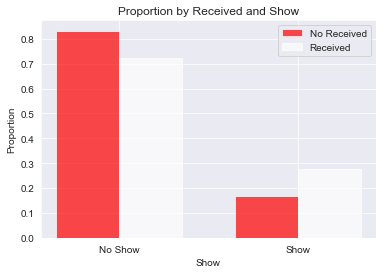

In [226]:
ind = np.arange(len(df_show_sms_received_no_pro))  # 组的 x 坐标位置
width = 0.35  # 条柱的宽度

# 绘制条柱
no_bars = plt.bar(
    ind,
    df_show_sms_received_no_pro,
    width,
    color='r',
    alpha=.7,
    label='No Received')
yes_bars = plt.bar(
    ind + width,
    df_show_sms_received_yes_pro,
    width,
    color='w',
    alpha=.7,
    label='Received')

# 标题和标签
plt.ylabel('Proportion')
plt.xlabel('Show')
plt.title('Proportion by Received and Show')
locations = ind + width / 2  # x 坐标刻度位置
labels = ['No Show', 'Show']  # x 坐标刻度标签
plt.xticks(locations, labels)

# 图例
plt.legend();

结果：

* 没有消息提醒的患者，实际就诊率 16.72%，有消息提醒的患者，实际就诊率 27.66%
* 因此有消息提醒的患者会倾向于就诊

<a id='conclusions'></a>

# 结论

结果：
* 在巴西实际就诊人群中，女性比例大。
* 预约时间和就诊时间间隔越大，实际就诊成功率越高。
* 巴西可预约医院20-30岁就诊人数最多，而70岁之后前往就诊人数最少。
* 办理家庭补助金患者更容易实践预约。
* 没有特殊疾病高血压（hypertension）、糖尿病（diabetes）、酗酒（alcoholism）的患者实际就诊成功率高，患有特殊疾病数量并不影响患者实际就诊成功率。
* 有消息提醒的患者会倾向于就诊。

分析过程遇到的问题：
* 在增加时间间隔字段时去除时间间隔异常数据，会影响其他问题的数据计算,但影响不大。
* 使用子集**只计算就诊的患者**，即子集 `df_show`，可以用来计算实际就诊率，解决大部分问题。